
# 2020-09-17 Artems Qubit

In [1]:
%matplotlib notebook
import logging

from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
from quantum_builder import QuantumBuilder
import scqubits as scq

plt.style.use('my_official')

FLUX = float
FLUX_NUMBER = int
cos = np.cos
sin = np.sin
pi = np.pi

fF = 10 ** (-15)
MY_COLOURS = {
    "DarkBlue": "#104e8b",     # dark blue (DodgerBlue4)
    "DarkRed": "#ed2200",     # dark red (red2)
    "Green": "#9acd32",     
    "Orange": "#ffc125",      # orange,
    "LightBlue": "#68838b",  # light steel blue,
    "Purple": "#6959cd",  # dark purple
    "Pink": "#ffa07a"  # pink salmon
}
CMAPS =  ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
COLORMAP_01 = ["#79cdcd", "#eead0e", "#9a37ff", "#00ee76"]
COLORMAP_12 = plt.get_cmap('Reds')
COLORMAP_ENERGY = plt.get_cmap('viridis')
COLORMAP_STATE = plt.get_cmap('hsv')

Phi0 = 2.067 * 10**(-15)

transmon_qubit_constant_manager:132:print_constants
⮑  ⚛ System setup with the following parameters (can choose to override them):

-----Energies-----
EC:                                               0.16 (GHz)
EJ0:                                              84.90 (GHz)

-----Raw Parameters-----
number_of_charge_states:                          21
jj_squares:                                       2.00 (fF)
C_transmon:                                       120.80 (fF)
C_gate:                                           0.00 (fF)

-----Derived Parameters-----
C_jj:                                             1.02 (fF)
C_𝛴 = C_transmon + C_gate + 2 * C_jj:             122.84 (fF)
Critical Current:                                 0.17 (µA)
JJ Resistance:                                    1.78 (k𝛀)


transmon_qubit_constant_manager:121:override_parameters
⮑  Overriding to the following values:
EC:       0.16
EJ0:      55


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

tran

<IPython.core.display.Javascript object>


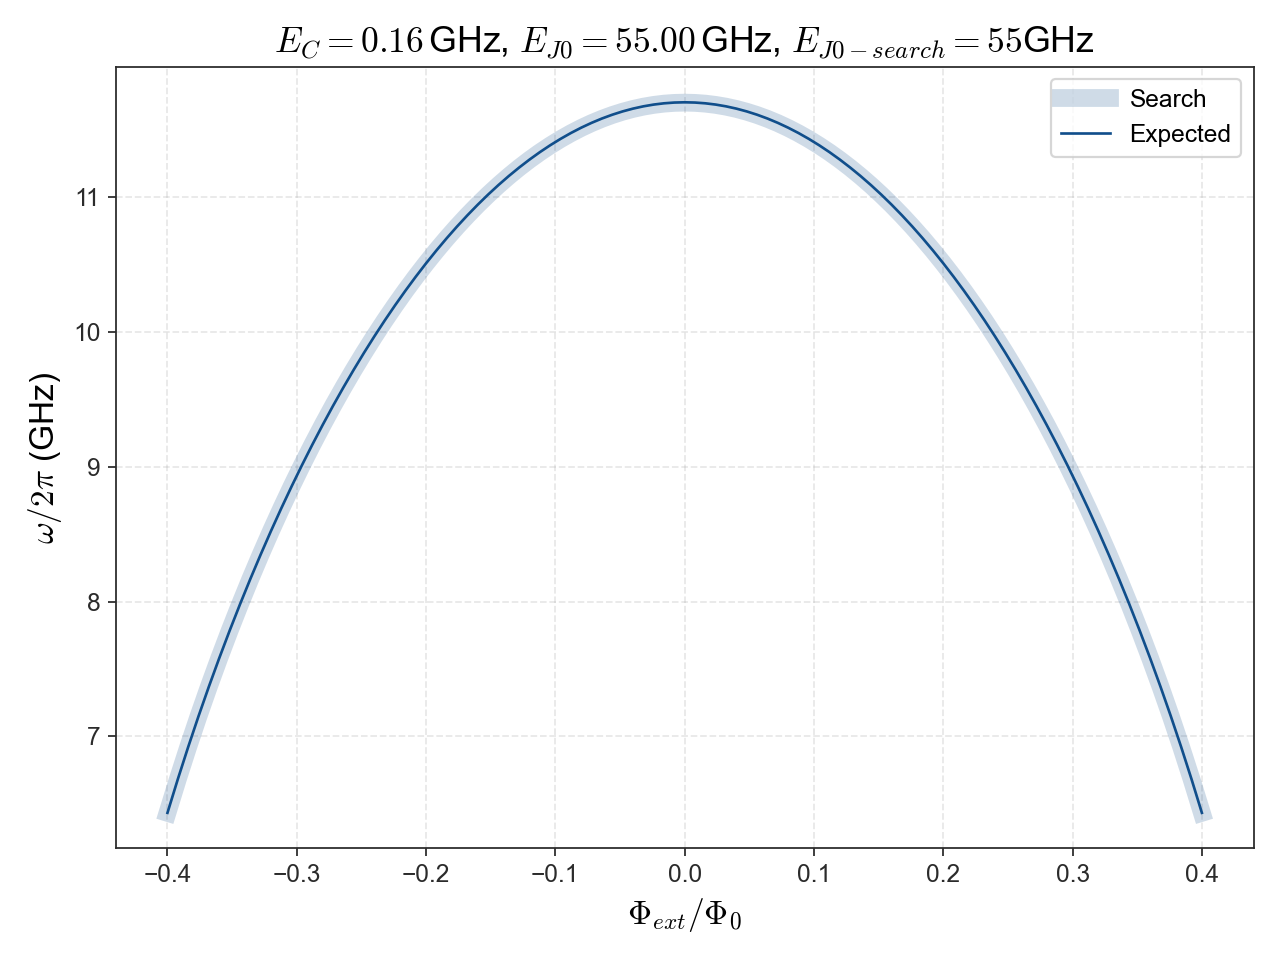

In [2]:
no_100x100_jj_squares = 2

# Simulation
# Distances will be in µm
L_gate = 0
C_gate = (L_gate / 10) * fF

L_transmon = 350
S_transmon = 24
C_transmon = (4 * (L_transmon - 2 * S_transmon) / 10) * fF

QUBIT_PARAMETERS = {
    "C_gate": C_gate,
    "C_transmon": C_transmon,
    "jj_squares": no_100x100_jj_squares,
    "number_of_charge_states": 21,
}
transmon_qubit = QuantumBuilder.build_transmon_qubit(
    QUBIT_PARAMETERS, logging_level=logging.INFO,
)
EC = 0.16
EJ0 = 55
transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)

N_ext_list = [0]
flux_ext_list = np.linspace(-0.4, 0.4, 101)
simulation = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list,
    flux_ext_list=flux_ext_list,
    number_of_levels_to_simulate=3,
    use_sparse_matrix=False)

# SCQ - used for exact
transmon = scq.TunableTransmon(
    EJmax=2*EJ0,
    EC=EC,
    d=0,  # no assymerty
    flux=0.0,  # defaults
    ng=0.0,
    ncut=21
)
scq_energies = transmon.get_spectrum_vs_paramvals(param_name='flux',
                                                  param_vals=flux_ext_list,
                                                  evals_count=2,
                                                  subtract_ground=False
                                                  ).energy_table
scq_01 = scq_energies[:, 1] - scq_energies[:, 0]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(flux_ext_list, scq_01,
        linestyle="-",
        color=MY_COLOURS["DarkBlue"],
        label="Search",
        linewidth=8,
        alpha=0.2
        )

transition01 = simulation["eigvals"][0, :, 1] - simulation["eigvals"][0, :, 0]
transition12 = simulation["eigvals"][0, :, 2] - simulation["eigvals"][0, :, 1]
ax.plot(flux_ext_list, transition01,
        linestyle="-",
        color=MY_COLOURS["DarkBlue"],
        label="Expected"
        )

# ax.set_xticks([-2, -1, 0, 1, 2])
# ax.set_ylim([6, 9])
# ax.set_xlim([0.004, 0.009])
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.set_ylabel("$\omega/2\pi$ (GHz)", fontsize=15)
ax.set_title(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}\,$GHz, $E_{{J0}}={transmon_qubit.transmon_qubit_constant_manager.EJ0:.2f}\,$GHz, $E_{{J0-search}}={EJ0}$GHz", fontsize=16)
ax.legend()
plt.tight_layout()

## $T_1$

### Load data

In [3]:
FILE_NAME = "./data/2020-10-23_xmon_measurements/2020-09-17_xmon_ay_q3_t1-14.txt"
with open(FILE_NAME) as fin:
    yargs = fin.readline().strip().split()
    ymin = float(yargs[1])
    ymax = float(yargs[2])  
    xargs= fin.readline().strip().split()
    xmin = float(xargs[1])
    xmax = float(xargs[2])

FileNotFoundError: [Errno 2] No such file or directory: './data/2020-10-23_xmon_measurements/2020-09-17_xmon_ay_q3_t1-14.txt'

In [22]:
from scipy.ndimage import gaussian_filter

data = np.loadtxt(FILE_NAME)
data = gaussian_filter(data, sigma = 2)
x_num = data.shape[1]
y_num = data.shape[0]

array([-6. , -5.8, -5.6, -5.4, -5.2, -5. , -4.8, -4.6, -4.4, -4.2, -4. ])

<IPython.core.display.Javascript object>


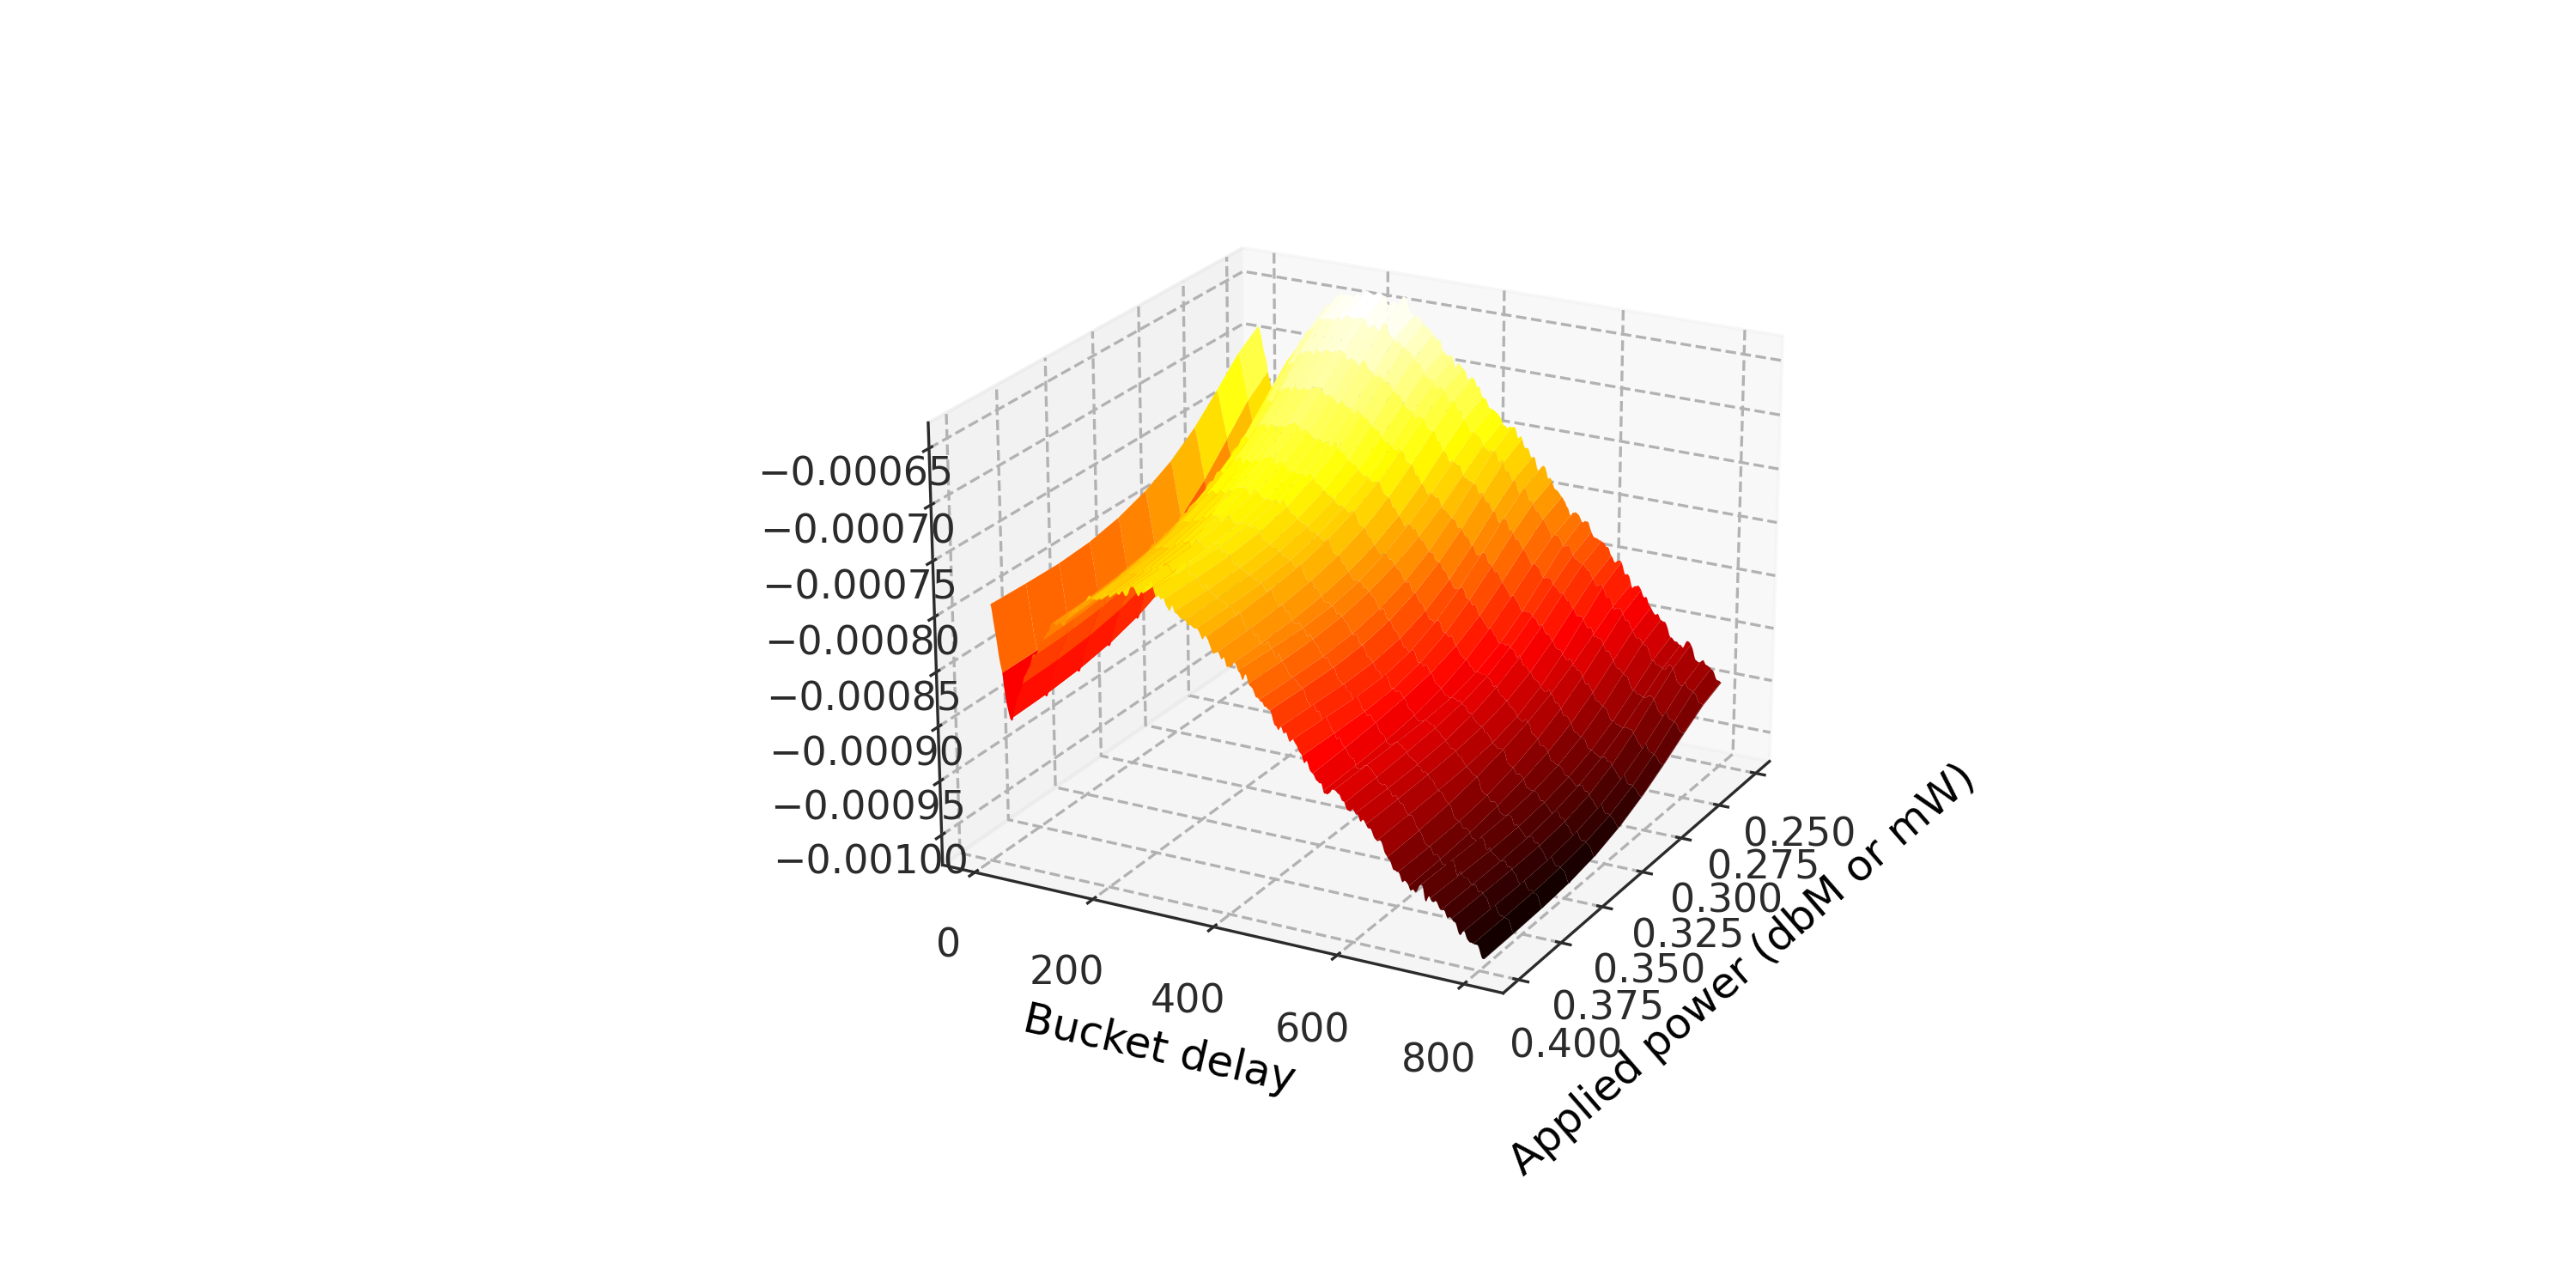

Text(0.5, 0, 'Applied power (dbM or mW)')

In [30]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

time_range = np.linspace(xmin, xmax, x_num)
power_range_in_dbm = np.linspace(ymin, ymax, y_num)
power_range_in_mW = [10**(x / 10) for x in power_range_in_dbm]

grid_x, grid_y = np.meshgrid(time_range, power_range_in_mW)
im = ax.plot_surface(
    grid_y,
    grid_x,
    data,
    cmap=cm.hot,
)
ax.set_ylabel("Bucket delay", fontsize=12)
ax.set_xlabel("Applied power (dbM or mW)", fontsize=12)

# Fitting simulations

Convert mA to flux:

\begin{equation}
n_\Phi = \frac{\Phi}{\Phi_0} =  I_{mA} \times \left(\text{Cell}_{T/A} \times 10^{-4}\right) \times \left(\text{Area}_{\mu m^2} \times 10^{-12}\right) \times \frac{1}{\Phi_0} = I_{mA} \times \text{Cell}_{T/A} \times \text{Area}_{\mu m^2} \times \frac{1}{\Phi_0 \times 10^{16}}
\end{equation}

## Tt Cell Q2
> - 350µm cross
> - 110nm x 110nm JJ
> - 5.91 x 4.18 µm2 area

transmon_qubit_constant_manager:132:print_constants
⮑  ⚛ System setup with the following parameters (can choose to override them):

-----Energies-----
EC:                                               0.16 (GHz)
EJ0:                                              51.36 (GHz)

-----Raw Parameters-----
number_of_charge_states:                          21
jj_squares:                                       1.21 (fF)
C_transmon:                                       120.80 (fF)
C_gate:                                           0.00 (fF)

-----Derived Parameters-----
C_jj:                                             0.62 (fF)
C_𝛴 = C_transmon + C_gate + 2 * C_jj:             122.03 (fF)
Critical Current:                                 0.10 (µA)
JJ Resistance:                                    2.95 (k𝛀)


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed



<IPython.core.display.Javascript object>


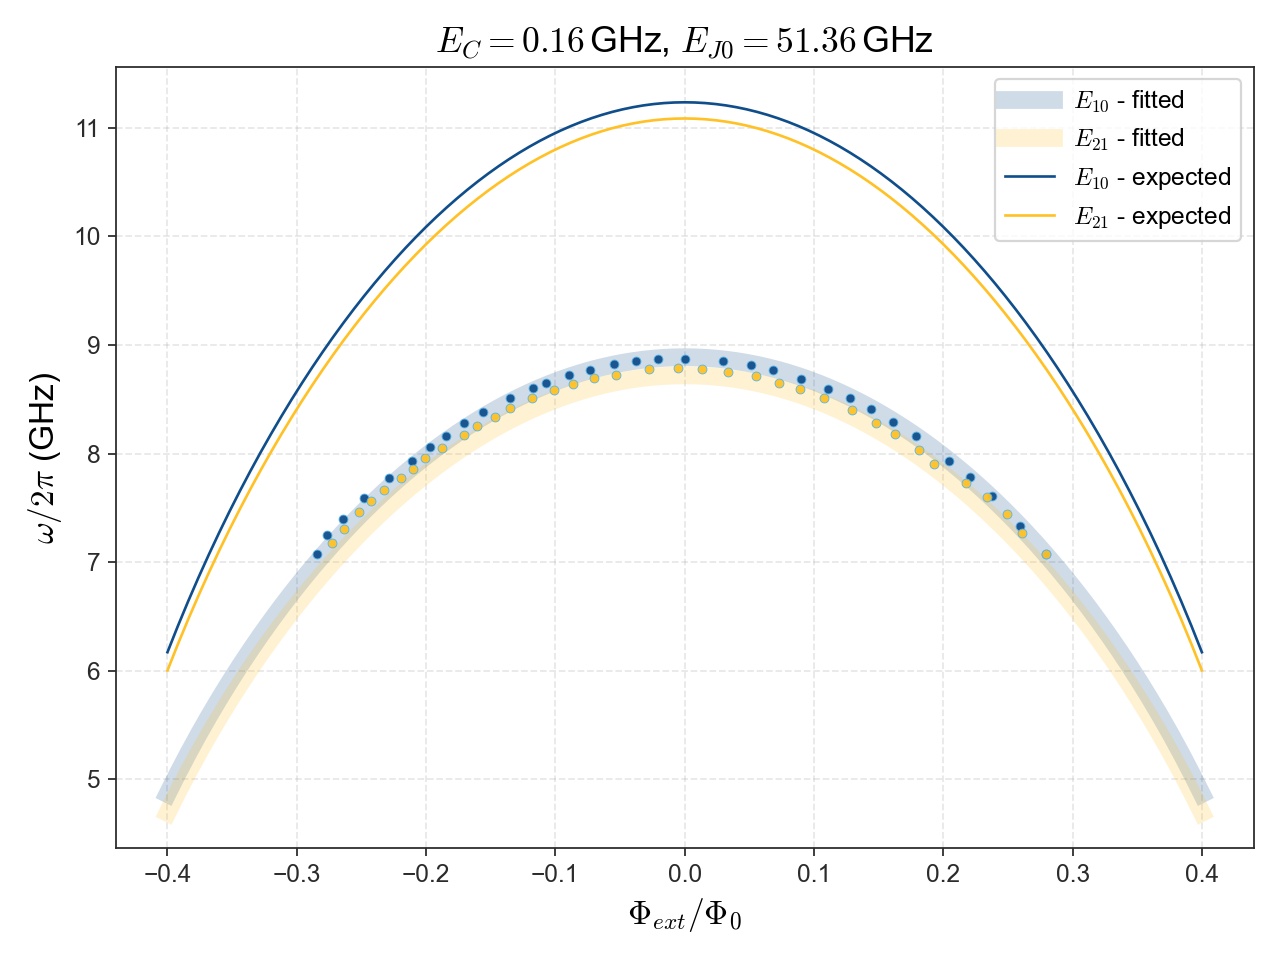

In [6]:
no_100x100_jj_squares = 1.1**2
AREA_µm2 = 5.91 * 4.18
mA_to_Gauss_AY = 22
FILE_NAME = "./data/2020-10_artem-xmon/2020-10-Tt/Qubit24_2020-09-17_xmon_Tt_Q2_two_tone_38_data_top.txt"
FILE_NAME_2 = "./data/2020-10_artem-xmon/2020-10-Tt/Qubit24_2020-09-17_xmon_Tt_Q2_two_tone_38_data_bottom.txt"


offset = 0.635
multiplier = 1

# Simulation
# Distances will be in µm
L_gate = 0
C_gate = (L_gate / 10) * fF

L_transmon = 350
S_transmon = 24
C_transmon = (4 * (L_transmon - 2 * S_transmon) / 10) * fF

QUBIT_PARAMETERS = {
    "C_gate": C_gate,
    "C_transmon": C_transmon,
    "jj_squares": no_100x100_jj_squares,
    "number_of_charge_states": 21,
}
transmon_qubit = QuantumBuilder.build_transmon_qubit(
    QUBIT_PARAMETERS, logging_level=logging.INFO,
)
EC = 0.16
EJ0 = 32
# transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)

N_ext_list = [0]
flux_ext_list = np.linspace(-0.4, 0.4, 101)
simulation = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list,
    flux_ext_list=flux_ext_list,
    number_of_levels_to_simulate=3,
    use_sparse_matrix=False)
transition01 = simulation["eigvals"][0, :, 1] - simulation["eigvals"][0, :, 0]
transition12 = simulation["eigvals"][0, :, 2] - simulation["eigvals"][0, :, 1]

# Experiment
with open(FILE_NAME) as fin:
    lines = (line for line in fin if not line.startswith('#'))
    qubit_data = np.loadtxt(lines)
# Convert mA to flux number
qubit_data[:, 0] = qubit_data[:, 0] * \
    mA_to_Gauss_AY * AREA_µm2 / (Phi0 * 10**(16))

with open(FILE_NAME_2) as fin:
    lines = (line for line in fin if not line.startswith('#'))
    qubit_data_2 = np.loadtxt(lines)
# Convert mA to flux number
qubit_data_2[:, 0] = qubit_data_2[:, 0] * \
    mA_to_Gauss_AY * AREA_µm2 / (Phi0 * 10**(16))

# SCQ
transmon = scq.TunableTransmon(
    EJmax=2*EJ0,
    EC=EC,
    d=0,  # no assymerty
    flux=0.0,  # defaults
    ng=0.0,
    ncut=21
)
scq_energies = transmon.get_spectrum_vs_paramvals(param_name='flux',
                                                  param_vals=flux_ext_list,
                                                  evals_count=3,
                                                  subtract_ground=False
                                                  ).energy_table
scq_01 = scq_energies[:, 1] - scq_energies[:, 0]
scq_12 = scq_energies[:, 2] - scq_energies[:, 1]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(flux_ext_list, scq_01,
        linestyle="-",
        color=MY_COLOURS["DarkBlue"],
        label="$E_{10}$ - fitted",
        linewidth=8,
        alpha=0.2
        )
ax.plot(flux_ext_list, scq_12,
        linestyle="-",
        color=MY_COLOURS["Orange"],
        label="$E_{21}$ - fitted",
        linewidth=8,
        alpha=0.2
        )

ax.plot((qubit_data[:, 0] - offset) * multiplier, qubit_data[:, 1] / 10**9,
        marker="o",
        color=MY_COLOURS["DarkBlue"],
        markeredgecolor="C2",
        markeredgewidth="0.4", markersize=4, alpha=0.95,
        linestyle="")

ax.plot((qubit_data_2[:, 0] - offset) * multiplier, qubit_data_2[:, 1] / 10**9,
        marker="o",
        color=MY_COLOURS["Orange"],
        markeredgecolor="C2",
        markeredgewidth="0.4", markersize=4, alpha=0.95,
        linestyle="")

ax.plot(flux_ext_list, transition01,
        linestyle="-",
        color=MY_COLOURS["DarkBlue"],
        label="$E_{10}$ - expected"
        )
ax.plot(flux_ext_list, transition12,
        linestyle="-",
        color=MY_COLOURS["Orange"],
        label="$E_{21}$ - expected"
        )

# ax.set_xticks([-2, -1, 0, 1, 2])
# ax.set_ylim([6, 9])
# ax.set_xlim([0.004, 0.009])
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.set_ylabel("$\omega/2\pi$ (GHz)", fontsize=15)
ax.set_title(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}\,$GHz, $E_{{J0}}={transmon_qubit.transmon_qubit_constant_manager.EJ0:.2f}\,$GHz", fontsize=16)
ax.legend()
plt.tight_layout()

plt.savefig("./output/2020-10_artem-xmon/tt_q2.png")

## Tt Cell Q3
> - 350µm cross
> - 120nm x 120nm JJ
> - 5.91 x 4.25 µm2 area

transmon_qubit_constant_manager:132:print_constants
⮑  ⚛ System setup with the following parameters (can choose to override them):

-----Energies-----
EC:                                               0.16 (GHz)
EJ0:                                              61.13 (GHz)

-----Raw Parameters-----
number_of_charge_states:                          21
jj_squares:                                       1.44 (fF)
C_transmon:                                       120.80 (fF)
C_gate:                                           0.00 (fF)

-----Derived Parameters-----
C_jj:                                             0.73 (fF)
C_𝛴 = C_transmon + C_gate + 2 * C_jj:             122.27 (fF)
Critical Current:                                 0.12 (µA)
JJ Resistance:                                    2.48 (k𝛀)


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed



<IPython.core.display.Javascript object>


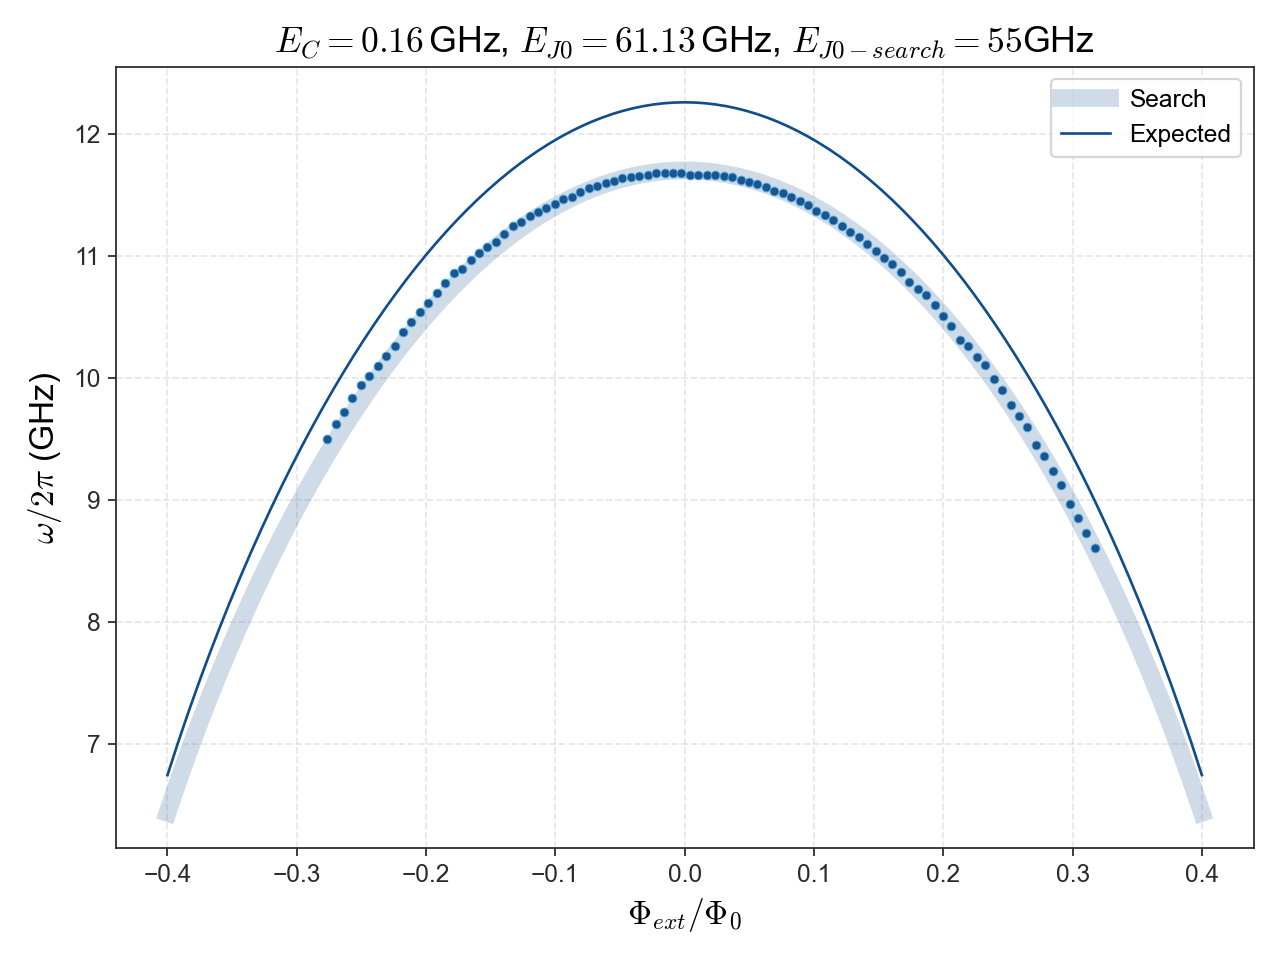

In [12]:
no_100x100_jj_squares = 1.2**2
AREA_µm2 = 5.91 * 4.25
mA_to_Gauss_AY = 21.48
FILE_NAME = "./data/2020-10_artem-xmon/2020-10-Tt/Qubit24_2020-09-17_xmon_Tt_Q3_two_tone_39_data.txt"

offset = 0.557
multiplier = 1

# Simulation
# Distances will be in µm
L_gate = 0
C_gate = (L_gate / 10) * fF

L_transmon = 350
S_transmon = 24
C_transmon = (4 * (L_transmon - 2 * S_transmon) / 10) * fF

QUBIT_PARAMETERS = {
    "C_gate": C_gate,
    "C_transmon": C_transmon,
    "jj_squares": no_100x100_jj_squares,
    "number_of_charge_states": 21,
}
transmon_qubit = QuantumBuilder.build_transmon_qubit(
    QUBIT_PARAMETERS, logging_level=logging.INFO,
)
EC = 0.16
EJ0 = 55
# transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)

N_ext_list = [0]
flux_ext_list = np.linspace(-0.4, 0.4, 101)
simulation = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list,
    flux_ext_list=flux_ext_list,
    number_of_levels_to_simulate=3,
    use_sparse_matrix=False)

# SCQ - used for exact
transmon = scq.TunableTransmon(
    EJmax=2*EJ0,
    EC=EC,
    d=0,  # no assymerty
    flux=0.0,  # defaults
    ng=0.0,
    ncut=21
)
scq_energies = transmon.get_spectrum_vs_paramvals(param_name='flux',
                                                  param_vals=flux_ext_list,
                                                  evals_count=2,
                                                  subtract_ground=False
                                                  ).energy_table
scq_01 = scq_energies[:, 1] - scq_energies[:, 0]

# Experiment
with open(FILE_NAME) as fin:
    lines = (line for line in fin if not line.startswith('#'))
    qubit_data = np.loadtxt(lines)
# Convert mA to flux number
qubit_data[:, 0] = qubit_data[:, 0] * \
    mA_to_Gauss_AY * AREA_µm2 / (Phi0 * 10**(16))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(flux_ext_list, scq_01,
        linestyle="-",
        color=MY_COLOURS["DarkBlue"],
        label="Search",
        linewidth=8,
        alpha=0.2
        )

ax.plot((qubit_data[:, 0] - offset) * multiplier, qubit_data[:, 1] / 10**9,
        marker="o",
        color=MY_COLOURS["DarkBlue"],
        markeredgecolor="C2",
        markeredgewidth="0.4", markersize=4, alpha=0.95,
        linestyle="")

transition01 = simulation["eigvals"][0, :, 1] - simulation["eigvals"][0, :, 0]
transition12 = simulation["eigvals"][0, :, 2] - simulation["eigvals"][0, :, 1]
ax.plot(flux_ext_list, transition01,
        linestyle="-",
        color=MY_COLOURS["DarkBlue"],
        label="Expected"
        )

# ax.set_xticks([-2, -1, 0, 1, 2])
# ax.set_ylim([6, 9])
# ax.set_xlim([0.004, 0.009])
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.set_ylabel("$\omega/2\pi$ (GHz)", fontsize=15)
ax.set_title(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}\,$GHz, $E_{{J0}}={transmon_qubit.transmon_qubit_constant_manager.EJ0:.2f}\,$GHz, $E_{{J0-search}}={EJ0}$GHz", fontsize=16)
ax.legend()
plt.tight_layout()

## Tt Cell Q4
> - 350µm cross
> - 130nm x 130nm JJ
> - 5.9 x 4.06 µm2 area

transmon_qubit_constant_manager:132:print_constants
⮑  ⚛ System setup with the following parameters (can choose to override them):

-----Energies-----
EC:                                               0.16 (GHz)
EJ0:                                              71.74 (GHz)

-----Raw Parameters-----
number_of_charge_states:                          21
jj_squares:                                       1.69 (fF)
C_transmon:                                       120.80 (fF)
C_gate:                                           0.00 (fF)

-----Derived Parameters-----
C_jj:                                             0.86 (fF)
C_𝛴 = C_transmon + C_gate + 2 * C_jj:             122.52 (fF)
Critical Current:                                 0.14 (µA)
JJ Resistance:                                    2.11 (k𝛀)


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed



<IPython.core.display.Javascript object>


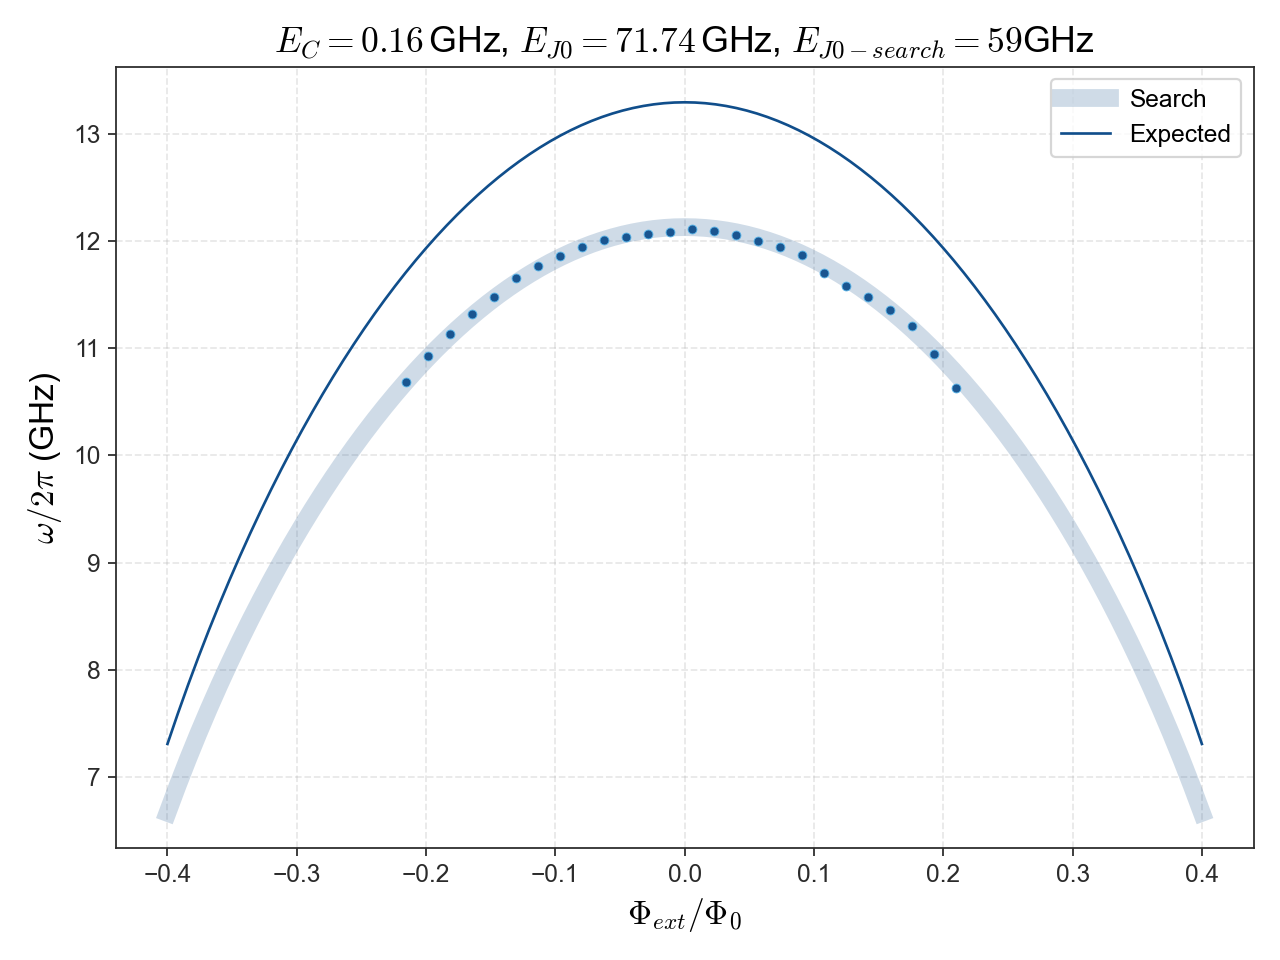

In [14]:
no_100x100_jj_squares = 1.3**2
AREA_µm2 = 5.9 * 4.06
mA_to_Gauss_AY = 29.35
FILE_NAME = "./data/2020-10_artem-xmon/2020-10-Tt/Qubit24_2020-09-17_xmon_Tt_two_tone_Q4_05_data.txt"

offset = 0.55
multiplier = 1

### Simulation
# Distances will be in µm
L_gate = 0
C_gate = (L_gate / 10) * fF

L_transmon = 350
S_transmon = 24
C_transmon = (4 * (L_transmon - 2 * S_transmon) / 10) * fF

QUBIT_PARAMETERS = {
    "C_gate": C_gate,
    "C_transmon": C_transmon,
    "jj_squares": no_100x100_jj_squares,
    "number_of_charge_states": 21,
}
transmon_qubit = QuantumBuilder.build_transmon_qubit(
    QUBIT_PARAMETERS, logging_level=logging.INFO,
)
EC = 0.16
EJ0 = 59
# transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)

N_ext_list = [0]
flux_ext_list = np.linspace(-0.4, 0.4, 101)
simulation = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list,
    flux_ext_list=flux_ext_list,
    number_of_levels_to_simulate=3,
    use_sparse_matrix=False)

# SCQ - used for exact
transmon = scq.TunableTransmon(
    EJmax=2*EJ0,
    EC=EC,
    d=0,  # no assymerty
    flux=0.0,  # defaults
    ng=0.0,
    ncut=21
)
scq_energies = transmon.get_spectrum_vs_paramvals(param_name='flux',
                                                  param_vals=flux_ext_list,
                                                  evals_count=2,
                                                  subtract_ground=False
                                                  ).energy_table
scq_01 = scq_energies[:, 1] - scq_energies[:, 0]

# Experiment
with open(FILE_NAME) as fin:
    lines = (line for line in fin if not line.startswith('#'))
    qubit_data = np.loadtxt(lines)
# Convert mA to flux number
qubit_data[:, 0] = qubit_data[:, 0] * \
    mA_to_Gauss_AY * AREA_µm2 / (Phi0 * 10**(16))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(flux_ext_list, scq_01,
        linestyle="-",
        color=MY_COLOURS["DarkBlue"],
        label="Search",
        linewidth=8,
        alpha=0.2
        )

ax.plot((qubit_data[:, 0] - offset) * multiplier, qubit_data[:, 1] / 10**9,
        marker="o",
        color=MY_COLOURS["DarkBlue"],
        markeredgecolor="C2",
        markeredgewidth="0.4", markersize=4, alpha=0.95,
        linestyle="")

transition01 = simulation["eigvals"][0, :, 1] - simulation["eigvals"][0, :, 0]
transition12 = simulation["eigvals"][0, :, 2] - simulation["eigvals"][0, :, 1]
ax.plot(flux_ext_list, transition01,
        linestyle="-",
        color=MY_COLOURS["DarkBlue"],
        label="Expected"
        )

# ax.set_xticks([-2, -1, 0, 1, 2])
# ax.set_ylim([6, 9])
# ax.set_xlim([0.004, 0.009])
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.set_ylabel("$\omega/2\pi$ (GHz)", fontsize=15)
ax.set_title(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}\,$GHz, $E_{{J0}}={transmon_qubit.transmon_qubit_constant_manager.EJ0:.2f}\,$GHz, $E_{{J0-search}}={EJ0}$GHz", fontsize=16)
ax.legend()
plt.tight_layout()

## AY Cell Q2
> - 350µm cross
> - 110nm x 110nm JJ
> - 5.91 x 4.18 µm2 area

transmon_qubit_constant_manager:132:print_constants
⮑  ⚛ System setup with the following parameters (can choose to override them):

-----Energies-----
EC:                                               0.16 (GHz)
EJ0:                                              51.36 (GHz)

-----Raw Parameters-----
number_of_charge_states:                          21
jj_squares:                                       1.21 (fF)
C_transmon:                                       120.80 (fF)
C_gate:                                           0.00 (fF)

-----Derived Parameters-----
C_jj:                                             0.62 (fF)
C_𝛴 = C_transmon + C_gate + 2 * C_jj:             122.03 (fF)
Critical Current:                                 0.10 (µA)
JJ Resistance:                                    2.95 (k𝛀)


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed



<IPython.core.display.Javascript object>


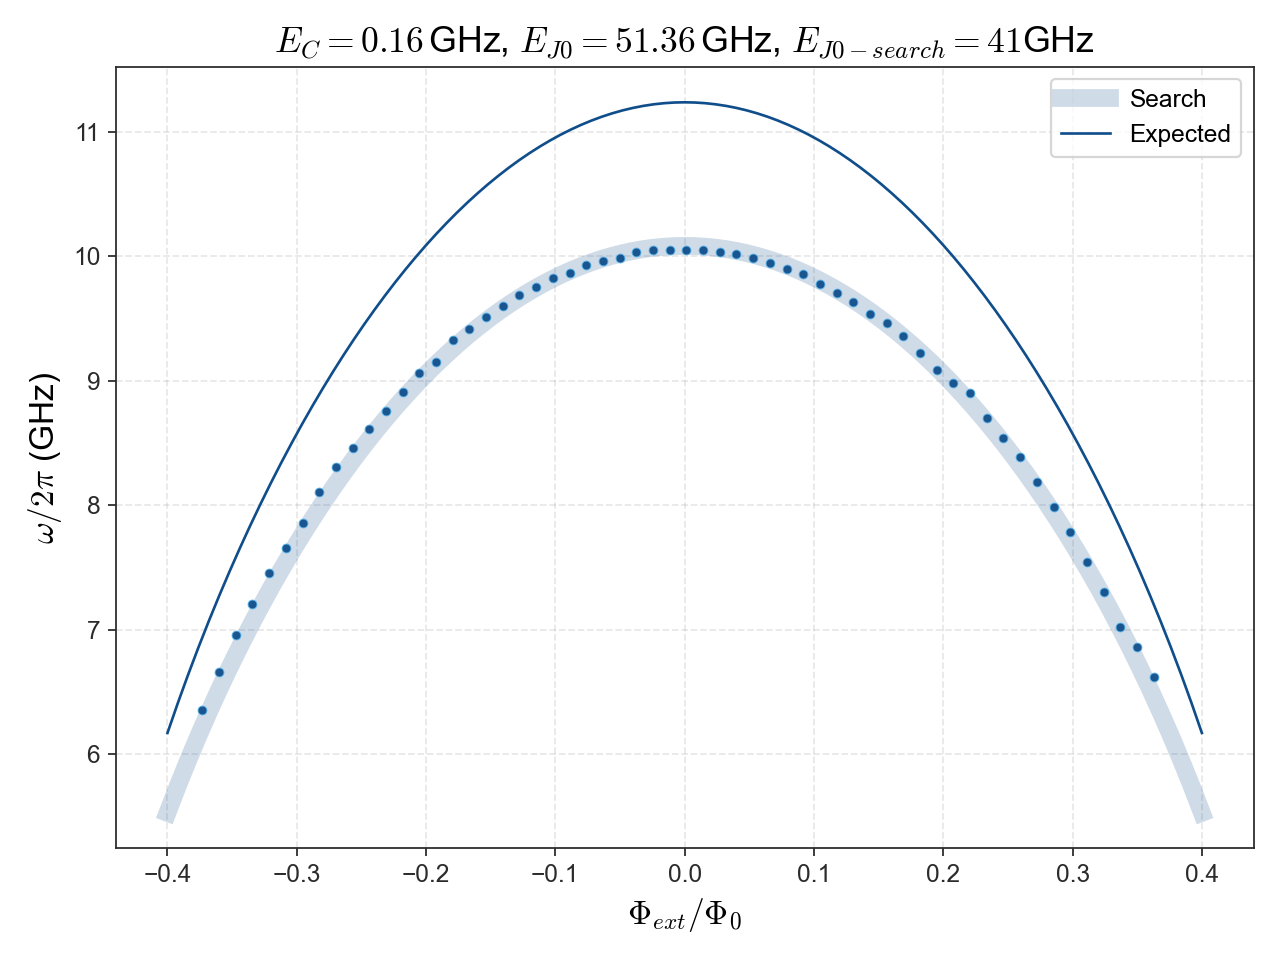

In [15]:
no_100x100_jj_squares = 1.1**2
AREA_µm2 = 5.91 * 4.18
mA_to_Gauss_AY = 21.6
FILE_NAME = "./data/2020-10_artem-xmon/2020-10-Ay/Qubit24_2020-09-17_xmon_Ay_two-tone_Q2_08_data.txt"

offset = 0.962
multiplier = 1

### Simulation
# Distances will be in µm
L_gate = 0
C_gate = (L_gate / 10) * fF

L_transmon = 350
S_transmon = 24
C_transmon = (4 * (L_transmon - 2 * S_transmon) / 10) * fF

QUBIT_PARAMETERS = {
    "C_gate": C_gate,
    "C_transmon": C_transmon,
    "jj_squares": no_100x100_jj_squares,
    "number_of_charge_states": 21,
}
transmon_qubit = QuantumBuilder.build_transmon_qubit(
    QUBIT_PARAMETERS, logging_level=logging.INFO,
)
EC = 0.16
EJ0 = 41
# transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)

N_ext_list = [0]
flux_ext_list = np.linspace(-0.4, 0.4, 101)
simulation = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list,
    flux_ext_list=flux_ext_list,
    number_of_levels_to_simulate=3,
    use_sparse_matrix=False)

# SCQ - used for exact
transmon = scq.TunableTransmon(
    EJmax=2*EJ0,
    EC=EC,
    d=0,  # no assymerty
    flux=0.0,  # defaults
    ng=0.0,
    ncut=21
)
scq_energies = transmon.get_spectrum_vs_paramvals(param_name='flux',
                                                  param_vals=flux_ext_list,
                                                  evals_count=2,
                                                  subtract_ground=False
                                                  ).energy_table
scq_01 = scq_energies[:, 1] - scq_energies[:, 0]

# Experiment
with open(FILE_NAME) as fin:
    lines = (line for line in fin if not line.startswith('#'))
    qubit_data = np.loadtxt(lines)
# Convert mA to flux number
qubit_data[:, 0] = qubit_data[:, 0] * \
    mA_to_Gauss_AY * AREA_µm2 / (Phi0 * 10**(16))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(flux_ext_list, scq_01,
        linestyle="-",
        color=MY_COLOURS["DarkBlue"],
        label="Search",
        linewidth=8,
        alpha=0.2
        )

ax.plot((qubit_data[:, 0] - offset) * multiplier, qubit_data[:, 1] / 10**9,
        marker="o",
        color=MY_COLOURS["DarkBlue"],
        markeredgecolor="C2",
        markeredgewidth="0.4", markersize=4, alpha=0.95,
        linestyle="")

transition01 = simulation["eigvals"][0, :, 1] - simulation["eigvals"][0, :, 0]
transition12 = simulation["eigvals"][0, :, 2] - simulation["eigvals"][0, :, 1]
ax.plot(flux_ext_list, transition01,
        linestyle="-",
        color=MY_COLOURS["DarkBlue"],
        label="Expected"
        )

# ax.set_xticks([-2, -1, 0, 1, 2])
# ax.set_ylim([6, 9])
# ax.set_xlim([0.004, 0.009])
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.set_ylabel("$\omega/2\pi$ (GHz)", fontsize=15)
ax.set_title(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}\,$GHz, $E_{{J0}}={transmon_qubit.transmon_qubit_constant_manager.EJ0:.2f}\,$GHz, $E_{{J0-search}}={EJ0}$GHz", fontsize=16)
ax.legend()
plt.tight_layout()

## AY Cell Q3
> - 350µm cross
> - 120nm x 120nm JJ
> - 5.91 x 4.25 µm2 area

transmon_qubit_constant_manager:132:print_constants
⮑  ⚛ System setup with the following parameters (can choose to override them):

-----Energies-----
EC:                                               0.16 (GHz)
EJ0:                                              61.13 (GHz)

-----Raw Parameters-----
number_of_charge_states:                          31
jj_squares:                                       1.44 (fF)
C_transmon:                                       120.80 (fF)
C_gate:                                           0.00 (fF)

-----Derived Parameters-----
C_jj:                                             0.73 (fF)
C_𝛴 = C_transmon + C_gate + 2 * C_jj:             122.27 (fF)
Critical Current:                                 0.12 (µA)
JJ Resistance:                                    2.48 (k𝛀)


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed



<IPython.core.display.Javascript object>


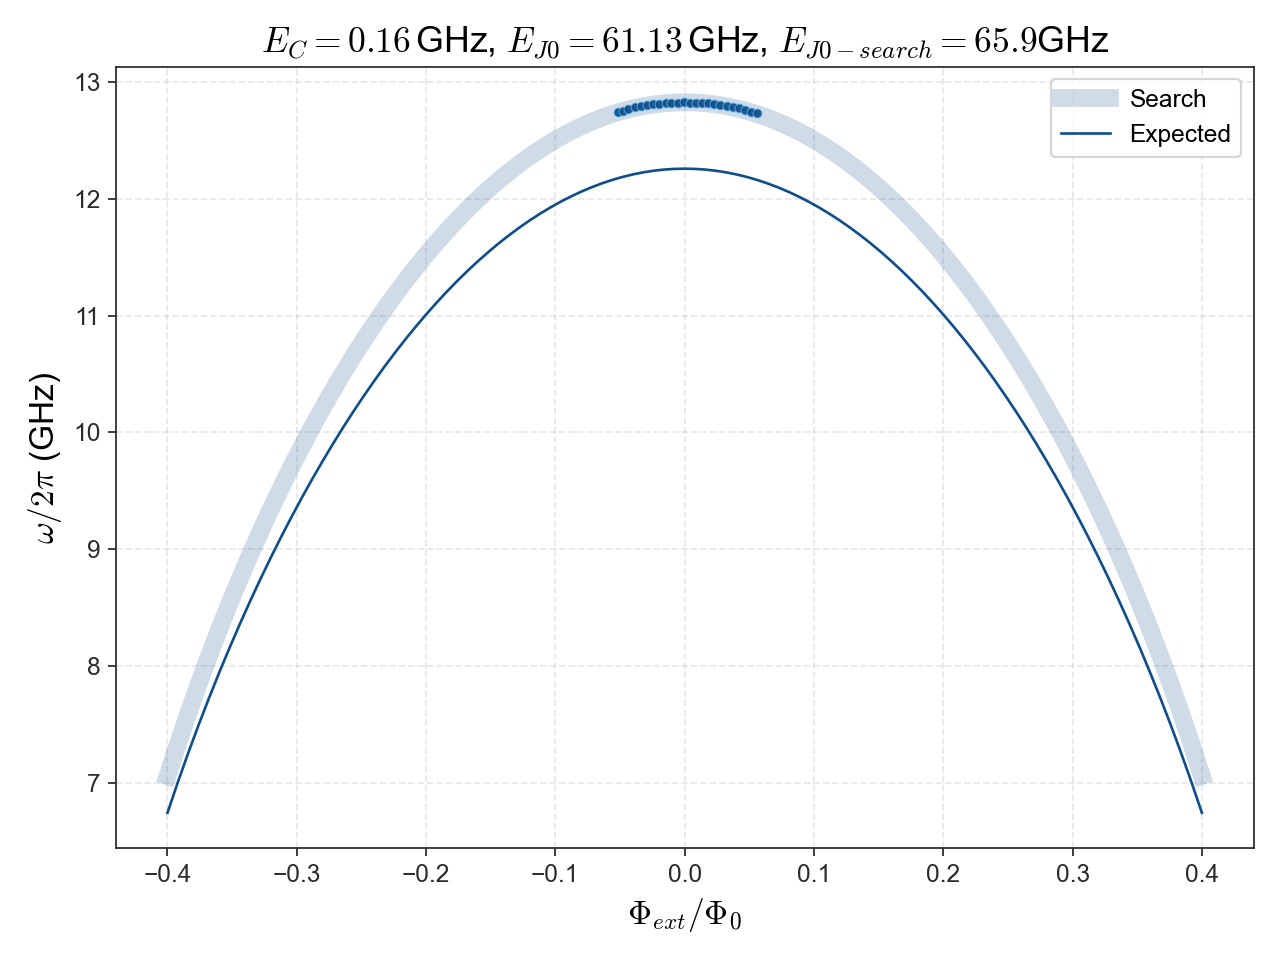

In [16]:
no_100x100_jj_squares = 1.2**2
AREA_µm2 = 5.91 * 4.25
mA_to_Gauss_AY = 19.5
FILE_NAME = "./data/2020-10_artem-xmon/2020-10-Ay/Qubit24_2020-09-17_xmon_Ay_Q3_2tone_10_data.txt"

offset = 0.15
multiplier = 1

### Simulation
# Distances will be in µm
L_gate = 0
C_gate = (L_gate / 10) * fF

L_transmon = 350
S_transmon = 24
C_transmon = (4 * (L_transmon - 2 * S_transmon) / 10) * fF

QUBIT_PARAMETERS = {
    "C_gate": C_gate,
    "C_transmon": C_transmon,
    "jj_squares": no_100x100_jj_squares,
    "number_of_charge_states": 31,
}
transmon_qubit = QuantumBuilder.build_transmon_qubit(
    QUBIT_PARAMETERS, logging_level=logging.INFO,
)
EC = 0.16
EJ0 = 65.9
# transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)

N_ext_list = [0]
flux_ext_list = np.linspace(-0.4, 0.4, 101)
simulation = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list,
    flux_ext_list=flux_ext_list,
    number_of_levels_to_simulate=3,
    use_sparse_matrix=False)

# SCQ - used for exact
transmon = scq.TunableTransmon(
    EJmax=2*EJ0,
    EC=EC,
    d=0,  # no assymerty
    flux=0.0,  # defaults
    ng=0.0,
    ncut=21
)
scq_energies = transmon.get_spectrum_vs_paramvals(param_name='flux',
                                                  param_vals=flux_ext_list,
                                                  evals_count=2,
                                                  subtract_ground=False
                                                  ).energy_table
scq_01 = scq_energies[:, 1] - scq_energies[:, 0]

# Experiment
with open(FILE_NAME) as fin:
    lines = (line for line in fin if not line.startswith('#'))
    qubit_data = np.loadtxt(lines)
# Convert mA to flux number
qubit_data[:, 0] = qubit_data[:, 0] * \
    mA_to_Gauss_AY * AREA_µm2 / (Phi0 * 10**(16))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(flux_ext_list, scq_01,
        linestyle="-",
        color=MY_COLOURS["DarkBlue"],
        label="Search",
        linewidth=8,
        alpha=0.2
        )

ax.plot((qubit_data[:, 0] - offset) * multiplier, qubit_data[:, 1] / 10**9,
        marker="o",
        color=MY_COLOURS["DarkBlue"],
        markeredgecolor="C2",
        markeredgewidth="0.4", markersize=4, alpha=0.95,
        linestyle="")

transition01 = simulation["eigvals"][0, :, 1] - simulation["eigvals"][0, :, 0]
transition12 = simulation["eigvals"][0, :, 2] - simulation["eigvals"][0, :, 1]
ax.plot(flux_ext_list, transition01,
        linestyle="-",
        color=MY_COLOURS["DarkBlue"],
        label="Expected"
        )

# ax.set_xticks([-2, -1, 0, 1, 2])
# ax.set_ylim([6, 9])
# ax.set_xlim([0.004, 0.009])
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.set_ylabel("$\omega/2\pi$ (GHz)", fontsize=15)
ax.set_title(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}\,$GHz, $E_{{J0}}={transmon_qubit.transmon_qubit_constant_manager.EJ0:.2f}\,$GHz, $E_{{J0-search}}={EJ0}$GHz", fontsize=16)
ax.legend()
plt.tight_layout()

## Ay Cell Q4
> - 350µm cross
> - 130nm x 130nm JJ
> - 5.9 x 4.06 µm2 area

transmon_qubit_constant_manager:132:print_constants
⮑  ⚛ System setup with the following parameters (can choose to override them):

-----Energies-----
EC:                                               0.16 (GHz)
EJ0:                                              71.74 (GHz)

-----Raw Parameters-----
number_of_charge_states:                          21
jj_squares:                                       1.69 (fF)
C_transmon:                                       120.80 (fF)
C_gate:                                           0.00 (fF)

-----Derived Parameters-----
C_jj:                                             0.86 (fF)
C_𝛴 = C_transmon + C_gate + 2 * C_jj:             122.52 (fF)
Critical Current:                                 0.14 (µA)
JJ Resistance:                                    2.11 (k𝛀)


transmon_qubit_simulator:60:simulate
⮑  💻 Running simulation

transmon_qubit_simulator:98:simulate
⮑  💻 Simulation completed



<IPython.core.display.Javascript object>


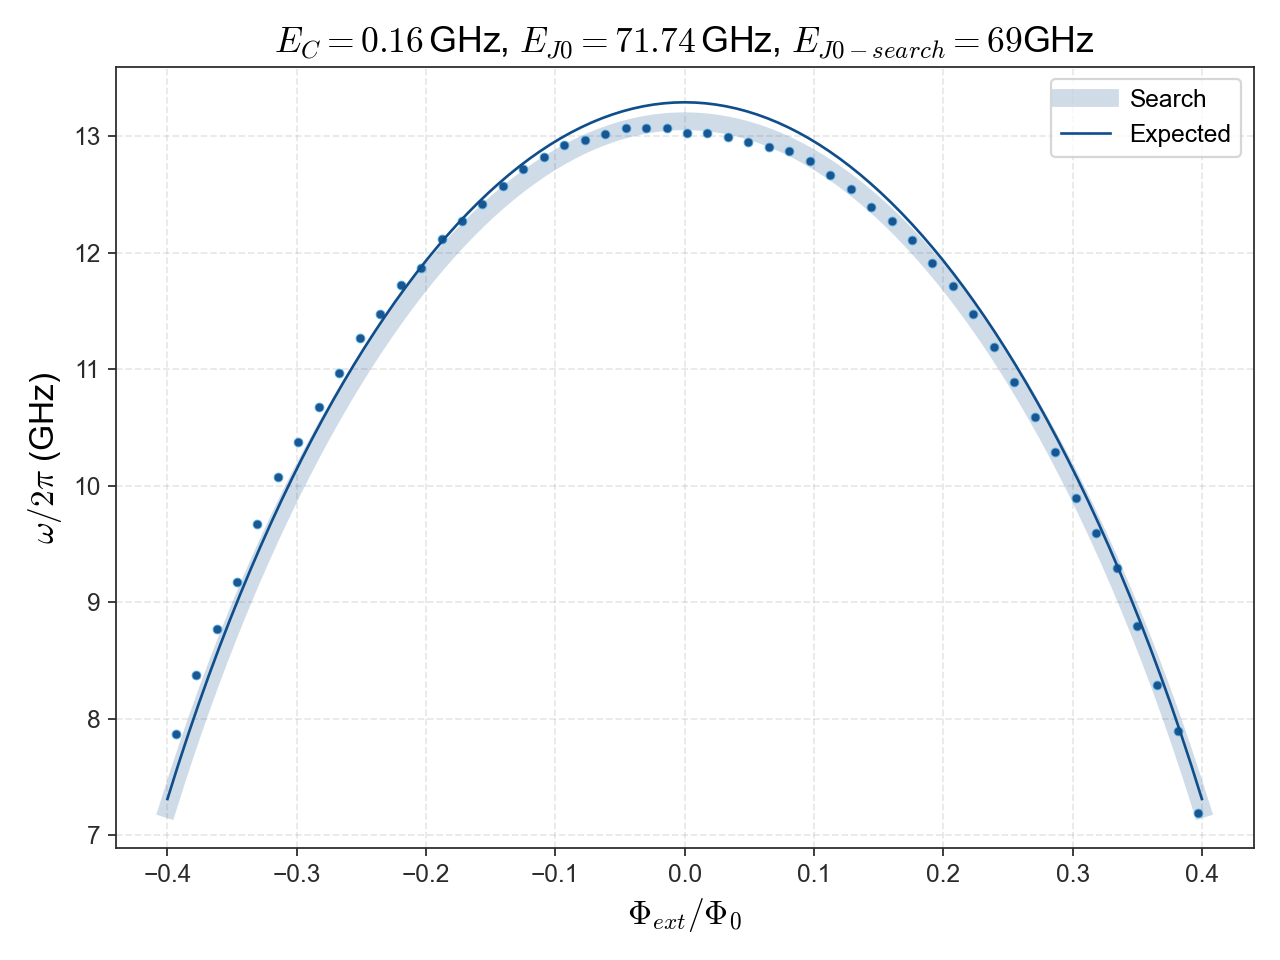

In [17]:
no_100x100_jj_squares = 1.3**2
AREA_µm2 = 5.9 * 4.06
mA_to_Gauss_AY = 27.3
FILE_NAME = "./data/2020-10_artem-xmon/2020-10-Ay/Qubit24_2020-09-17_xmon_Ay_two-tone_Q4_06_data.txt"

offset = 0.85
multiplier = 1

### Simulation
# Distances will be in µm
L_gate = 0
C_gate = (L_gate / 10) * fF

L_transmon = 350
S_transmon = 24
C_transmon = (4 * (L_transmon - 2 * S_transmon) / 10) * fF

QUBIT_PARAMETERS = {
    "C_gate": C_gate,
    "C_transmon": C_transmon,
    "jj_squares": no_100x100_jj_squares,
    "number_of_charge_states": 21,
}
transmon_qubit = QuantumBuilder.build_transmon_qubit(
    QUBIT_PARAMETERS, logging_level=logging.INFO,
)
EC = 0.16
EJ0 = 69
# transmon_qubit.transmon_qubit_constant_manager.override_parameters(EC, EJ0)

N_ext_list = [0]
flux_ext_list = np.linspace(-0.4, 0.4, 101)
simulation = transmon_qubit.transmon_qubit_simulator.simulate(
    N_ext_list=N_ext_list,
    flux_ext_list=flux_ext_list,
    number_of_levels_to_simulate=3,
    use_sparse_matrix=False)

# SCQ - used for exact
transmon = scq.TunableTransmon(
    EJmax=2*EJ0,
    EC=EC,
    d=0,  # no assymerty
    flux=0.0,  # defaults
    ng=0.0,
    ncut=21
)
scq_energies = transmon.get_spectrum_vs_paramvals(param_name='flux',
                                                  param_vals=flux_ext_list,
                                                  evals_count=2,
                                                  subtract_ground=False
                                                  ).energy_table
scq_01 = scq_energies[:, 1] - scq_energies[:, 0]

# Experiment
with open(FILE_NAME) as fin:
    lines = (line for line in fin if not line.startswith('#'))
    qubit_data = np.loadtxt(lines)
# Convert mA to flux number
qubit_data[:, 0] = qubit_data[:, 0] * \
    mA_to_Gauss_AY * AREA_µm2 / (Phi0 * 10**(16))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(flux_ext_list, scq_01,
        linestyle="-",
        color=MY_COLOURS["DarkBlue"],
        label="Search",
        linewidth=8,
        alpha=0.2
        )

ax.plot((qubit_data[:, 0] - offset) * multiplier, qubit_data[:, 1] / 10**9,
        marker="o",
        color=MY_COLOURS["DarkBlue"],
        markeredgecolor="C2",
        markeredgewidth="0.4", markersize=4, alpha=0.95,
        linestyle="")

transition01 = simulation["eigvals"][0, :, 1] - simulation["eigvals"][0, :, 0]
transition12 = simulation["eigvals"][0, :, 2] - simulation["eigvals"][0, :, 1]
ax.plot(flux_ext_list, transition01,
        linestyle="-",
        color=MY_COLOURS["DarkBlue"],
        label="Expected"
        )

# ax.set_xticks([-2, -1, 0, 1, 2])
# ax.set_ylim([6, 9])
# ax.set_xlim([0.004, 0.009])
ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
ax.set_ylabel("$\omega/2\pi$ (GHz)", fontsize=15)
ax.set_title(f"$E_C={transmon_qubit.transmon_qubit_constant_manager.EC:.2f}\,$GHz, $E_{{J0}}={transmon_qubit.transmon_qubit_constant_manager.EJ0:.2f}\,$GHz, $E_{{J0-search}}={EJ0}$GHz", fontsize=16)
ax.legend()
plt.tight_layout()